# Confidence Intervals and the CLT

*Purpose*: When studying sampled data, we need a principled way to report our results with their uncertainties. Confidence intervals (CI) are an excellent way to summarize results, and the central limit theorem (CLT) helps us to construct these intervals.


## Setup


In [1]:
import grama as gr
DF = gr.Intention()
%matplotlib inline

# Theory Fundamentals

## Motivation: Limited data means error


In [2]:
## NOTE: No need to edit; run and inspect
# Define an uncertain quantity
mg_test = gr.marg_mom(
    "uniform", 
    mean=0, 
    sd=1,
)

mg_test


/Users/zach/Git/py_grama/grama/marginals.py:336: RuntimeWarning: divide by zero encountered in double_scalars


(+0) uniform, {'mean': '0.000e+00', 's.d.': '1.000e+00', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}

From this marginal summary, we can see that the mean of the distribution is `0`. However, if we have limited data then the mean of that sample will generally not be exactly zero:


In [3]:
## NOTE: No need to edit; run and inspect
gr.mean(mg_test.r(10))


-0.0665664741051046

Limited data leads to a form of error called *sampling error*. In practice we *almost always* have limited data, so sampling error is an unavoidable reality.

Since sampling error is unavoidable, we would like to know *how much* sampling error there is in a given quantity. The central limit theorem (CLT) helps us quantify sampling error.


## Central Limit Theorem

Let $X \sim \rho$ be a random quantity with mean $\mu$ and variance $\sigma^2$ not infinite. The sample mean is denoted $\overline{X}_n$, and is defined as

$$\overline{X}_n = \frac{1}{n} \sum_{i=1}^n X_i.$$

Under independent, repeated observations from the same distribution $X_i \sim \rho$, the central limit theorem states that $\overline{X}_n$ becomes increasingly normal in its distribution as $n$ is increased, regardless of the original distribution $\rho$. That is

$$\overline{X}_n \stackrel{d}{\to} N(\mu, \sigma^2/n)$$

The CLT is useful because it gives us a way to quantify sampling error: Since the CLT holds regardless of where the data came from $X \sim \rho$---so long as $|\mu| < \infty, \sigma < \infty$---then we can characterize the sampling error in the sample mean $\overline{X}_n$.


### __qX__ Study CLT convergence behavior


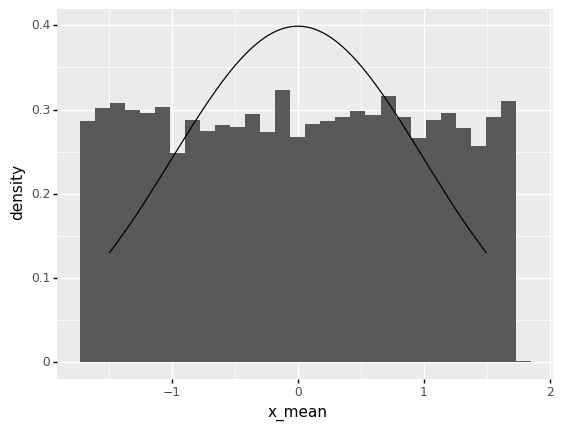

<ggplot: (8780525750279)>

In [4]:
## TODO: Adjust the sample size n
n = 1 # Sample size

## NOTE: No need to edit
# Draw a large sample
df_sample = gr.df_make(x=mg_test.r(5000))

(
    # Compute mean within each group
    df_sample
    >> gr.tf_mutate(i=DF.index // n)
    >> gr.tf_group_by(DF.i)
    >> gr.tf_summarize(
        x_mean=gr.mean(DF.x)
    )
    >> gr.tf_ungroup()
    
    # Visualize
    >> gr.ggplot(gr.aes("x_mean"))
    + gr.geom_histogram(gr.aes(y="stat(density)"), bins=30)
    + gr.geom_line(
        data=gr.df_make(x_mean=gr.linspace(-1.5, +1.5, 100))
        >> gr.tf_mutate(
            d=gr.marg_mom("norm", mean=0, sd=1/gr.sqrt(n)).d(DF.x_mean)
        ),
        mapping=gr.aes(y="d"),
    )
)

*Observations*

<!-- task-begin -->
- Around what value of $n$ does the histogram start to look like the normal distribution (black curve)?
  - (Your response here)
- How does the "width" of the histogram change with $n$?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Around what value of $n$ does the histogram start to look like the normal distribution (black curve)?
  - Around values of $n > 10$ the histogram starts to look like a normal distribution.
- How does the "width" of the histogram change with $n$?
  - The "width" of the histogram tends to shrink with large $n$, but it shrinks very slowly.
<!-- solution-end -->


## Confidence Intervals

The CLT-based confidence interval for the mean is given by

$$[\overline{X}_n - z_C \sigma/\sqrt{n}, \overline{X}_n + z_C \sigma/\sqrt{n}]$$

where $z_C$ is the relevant quantile of a standard normal distribution. This is based on capturing a specified fraction $C$ of the distribution between the interval bounds. For instance, the following code computes $z_C$ for $C = 0.99$.


In [5]:
## NOTE: No need to edit, this compute the relevant
C = 0.99 # 99% confidence level
mg_standard = gr.marg_mom("norm", mean=0, sd=1)
z_C = mg_standard.q(1 - (1 - C)/2)
print("z_C = {0:4.3f}".format(z_C))


z_C = 2.576


You can compute these CI bounds manually. However, the helper functions `gr.mean_lo()` and `gr.mean_up()` automate these calculations.

### __qX__ Compute a confidence interval

Use the helper functions `gr.mean_lo()` and `gr.mean_up()` to compute confidence limits for the mean.


In [6]:
## TODO: Compute confidence limits for the mean;
# 
n = 10

df_ci = (
    gr.df_make(x=mg_test.r(n))
    >> gr.tf_summarize(
# solution-begin
        x_lo=gr.mean_lo(DF.x),
# solution-end
# task-begin
        # x_lo=???
# task-end
        x_mean=gr.mean(DF.x),
# solution-begin
        x_up=gr.mean_up(DF.x),
# solution-end
# task-begin
        # x_up=???
# task-end
    )
)

## NOTE: Use this to check your work
assert \
    "x_lo" in df_ci.columns, \
    "You must compute x_lo"
assert \
    "x_up" in df_ci.columns, \
    "You must compute x_up"
assert \
    df_ci.x_lo[0] < df_ci.x_mean[0], \
    "x_lo should be smaller than x_mean"
assert \
    df_ci.x_mean[0] < df_ci.x_up[0], \
    "x_mean should be smaller than x_up"

df_ci

,x_lo,x_mean,x_up
0,-0.736378,-0.018733,0.698913


### __qX__ Study the CI width

The following code creates confidence intervals for samples of different sizes $n$. Run the following code, inspect the results, and answer the questions under *observations* below.


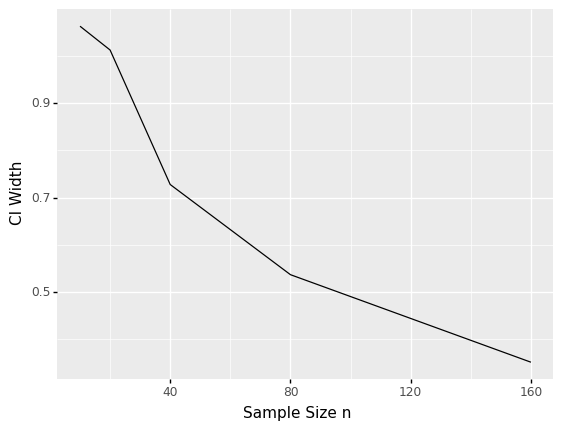

<ggplot: (8780525612719)>

In [7]:
## NOTE: No need to edit
df_sweep = gr.df_grid()
for i in [10, 20, 40, 80, 160]:
    df_sweep = (
        df_sweep
        >> gr.tf_bind_rows(
            gr.df_make(x=mg_test.r(i))
            >> gr.tf_summarize(
                x_lo=gr.mean_lo(DF.x),
                x_up=gr.mean_up(DF.x),
            )
            >> gr.tf_mutate(
                ci_width=DF.x_up - DF.x_lo,
                n=i,
            )
        )
    )
    
(
    df_sweep
    >> gr.ggplot(gr.aes("n", "ci_width"))
    + gr.geom_line()
    + gr.labs(
        x="Sample Size n",
        y="CI Width",
    )
)

*Observations*

<!-- task-begin -->
- Compare the CI width behavior (figure immediately above) with the definition given earlier. What explains the curve above?
  - (Your response here)
- To halve the CI width, how would you need to change the sample size?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Compare the CI width behavior (figure immediately above) with the definition given earlier. What explains the curve above?
  - The CI expression contains a $\sigma/\sqrt{n}$ term; the $1/\sqrt{n}$ behavior is what we see above.
- To halve the CI width, how would you need to change the sample size?
  - To halve the CI width, you would need to quadruple the sample size; note that the width goes as $1/\sqrt{n}$, thus $1/\sqrt{4n} = 1/(2\sqrt{n})$. 
<!-- solution-end -->

# Interpreting Confidence Intervals

## Golden Rule of Confidence Intervals

```{admonition} The "Golden Rule" for interpreting Confidence Intervals
When interpreting a confidence interval, we should assume the true value could be anywhere inside the interval.
```


### __qX__ Interpret these intervals

Study the following intervals, answer the questions under *observations* below.


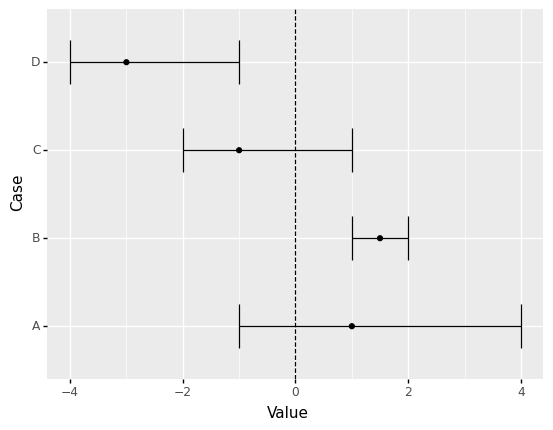

<ggplot: (8780526099493)>

In [16]:
## NOTE: No need to edit; run and inspect
(
    gr.df_make(
        case=["A", "B", "C", "D"],
        x_lo=[ -1,   1,  -2,  -4],
        x_mu=[  1, 1.5,  -1,  -3],
        x_up=[  4,   2,   1,  -1],
    )
    >> gr.ggplot(gr.aes("case"))
    + gr.geom_errorbar(gr.aes(ymin="x_lo", ymax="x_up"))
    + gr.geom_point(gr.aes(y="x_mu"))
    + gr.geom_hline(yintercept=0, linetype="dashed")
    + gr.coord_flip()
    + gr.labs(
        y="Value",
        x="Case",
    )
)

*Observations*

<!-- task-begin -->
- Is Case A greater than zero?
  - (Your response here)
- Is Case B greater than zero?
  - (Your response here)
- Is Case C less than zero?
  - (Your response here)
- Is Case D less than zero?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Is Case A greater than zero?
  - Unclear; the confidence interval includes zero, so A could very well be negative.
- Is Case B greater than zero?
  - Most likely yes; the entire confidence interval is greater than zero.
- Is Case C less than zero?
  - Unclear; the confidence interval includes zero, so C could very well be positive.
- Is Case D less than zero?
  - Most likely yes; the entire confidence interval is less than zero.
<!-- solution-end -->

## Circuit example


In [9]:
from grama.models import make_prlc_rand
md_circuit = make_prlc_rand()

### __qX__ 


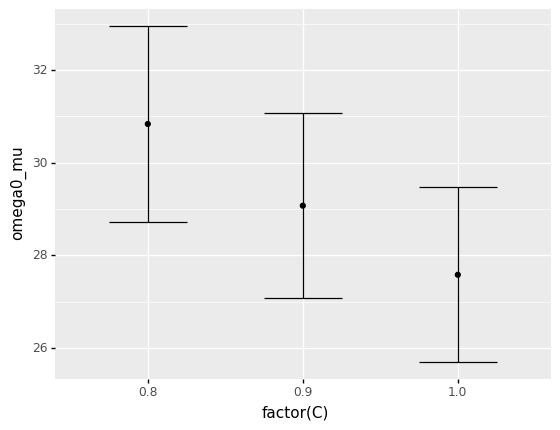

<ggplot: (8780526611279)>

In [10]:
(
    md_circuit
    >> gr.ev_sample(
        n=20, 
        df_det=gr.df_make(R=1, L=1e-3, C=[0.8, 0.9, 1]),
    )
    >> gr.tf_group_by(DF.C)
    >> gr.tf_summarize(
        omega0_lo=gr.mean_lo(DF.omega0),
        omega0_mu=gr.mean(DF.omega0),
        omega0_up=gr.mean_up(DF.omega0),
    )
    
    >> gr.ggplot(gr.aes("factor(C)"))
    + gr.geom_errorbar(gr.aes(ymin="omega0_lo", ymax="omega0_up"))
    + gr.geom_point(gr.aes(y="omega0_mu"))
)

## Assessing differences

While comparing confidence intervals is better than ignoring uncertainty,


# Adjusting Sample Size


# Probability Estimation


In [11]:
from grama.models import make_cantilever_beam
md_beam = make_cantilever_beam()

In [12]:
(
    md_beam
    >> gr.ev_sample(n=1e4, df_det="nom")
    >> gr.tf_summarize(
        pof_stress=gr.pr(DF.g_stress <= 0),
        pof_joint=gr.pr( (DF.g_stress <= 0) & (DF.g_disp <= 0) ),
        pof_either=gr.pr( (DF.g_stress <= 0) | (DF.g_disp <= 0) ),
    )
)

eval_sample() is rounding n...


,pof_stress,pof_joint,pof_either
0,0.0359,0.0134,0.0682


In [13]:
(
    md_beam
    >> gr.ev_sample(n=20, df_det="nom")
    >> gr.tf_summarize(
        pof_lo=gr.pr_lo(DF.g_stress <= 0),
        pof=gr.pr(DF.g_stress <= 0),
        pof_up=gr.pr_up(DF.g_stress <= 0),
    )
)

,pof_lo,pof,pof_up
0,0.0,0.0,0.249105


# Real vs Error


### __qX__ 

(TODO Some exercise emphasizing when to take a mean or a probability)
